# Plot Backend

Plots the APE, RPE and trajectory against ground truth for the final backend output trajectory.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

from evaluation.evaluation_lib import (
    get_ape_trans, 
    get_ape_rot, 
    get_rpe_trans, 
    get_rpe_rot,
    plot_metric, 
    plot_traj_colormap_ape, 
    plot_traj_colormap_rpe,
    convert_abs_traj_to_rel_traj
)

#%matplotlib inline
#%matplotlib widget
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import mpl_toolkits.mplot3d.art3d as art3d

from evaluation.tools import website_utils as web

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [7]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/tonirv/datasets/kimera_rig/output_logs/"
gt_data_file = ""

In [27]:
def rename_pim_df(df):
    """ Renames a DataFrame built from a PIM measurements csv file to be converted to a trajectory.
    
        This is an 'inplace' argument and returns nothing.
    
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={"tx": "x",
                       "ty": "y",
                       "tz": "z"}, inplace=True)

# show coordinate axes
def colored_line_collection(xyz, colors, plot_mode=plot.PlotMode.xy,
                            linestyles="solid", step=2, alpha=1.):
    if len(xyz) / step != len(colors):
        raise PlotException(
            "color values don't have correct length: %d vs. %d" %
            (len(xyz) / step, len(colors)))
    x_idx, y_idx, z_idx = plot.plot_mode_to_idx(plot_mode)
    xs = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, x_idx], xyz[1::step, x_idx])]
    ys = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, y_idx], xyz[1::step, y_idx])]
    if plot_mode == plot.PlotMode.xyz:
        zs = [[x_1, x_2]
              for x_1, x_2 in zip(xyz[:-1:step, z_idx], xyz[1::step, z_idx])]
        segs = [list(zip(x, y, z)) for x, y, z in zip(xs, ys, zs)]
        line_collection = art3d.Line3DCollection(segs, colors=colors,
                                                 alpha=alpha,
                                                 linestyles=linestyles)
    else:
        segs = [list(zip(x, y)) for x, y in zip(xs, ys)]
        line_collection = LineCollection(segs, colors=colors, alpha=alpha,
                                         linestyle=linestyles)
    return line_collection

def draw_coordinate_axes(ax, traj, plot_mode, downsample_ratio=20, marker_scale=1, x_color="r",
                         y_color="g", z_color="b"):
    """
    Draws a coordinate frame axis for each pose of a trajectory.
    :param ax: plot axis
    :param traj: trajectory.PosePath3D or trajectory.PoseTrajectory3D object
    :param plot_mode: PlotMode value
    :param marker_scale: affects the size of the marker (1. * marker_scale)
    :param x_color: color of the x-axis
    :param y_color: color of the y-axis
    :param z_color: color of the z-axis
    """
    if marker_scale <= 0:
        return

    unit_x = np.array([1 * marker_scale, 0, 0, 1])
    unit_y = np.array([0, 1 * marker_scale, 0, 1])
    unit_z = np.array([0, 0, 1 * marker_scale, 1])

    # Transform start/end vertices of each axis to global frame.
    x_vertices = np.array([[p[:3, 3], p.dot(unit_x)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    y_vertices = np.array([[p[:3, 3], p.dot(unit_y)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    z_vertices = np.array([[p[:3, 3], p.dot(unit_z)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])

    n = len(traj.poses_se3[::downsample_ratio])
    # Concatenate all line segment vertices in order x, y, z.
    vertices = np.concatenate((x_vertices, y_vertices, z_vertices)).reshape(
        (n * 2 * 3, 3))
    # Concatenate all colors per line segment in order x, y, z.
    colors = np.array(n * [x_color] + n * [y_color] + n * [z_color])

    markers = colored_line_collection(vertices, colors, plot_mode, step=2)
    ax.add_collection(markers)
    
def draw_start_and_end(ax, traj, plot_mode):
    """Draw start and end points of the trajectory
    """
    start_pose = traj.poses_se3[0]
    end_pose = traj.poses_se3[-1]
    if plot_mode == plot.PlotMode.xy:
        ax.plot(start_pose[0,3], start_pose[1,3], 'bo')
        ax.plot(end_pose[0,3], end_pose[1,3], 'rx')

## Backend Trajectory

Associate, align and process the trajectory as determined by the backend. Note that this does not include loop closure factors or other optimizations. This is pure VIO.

In [28]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "traj_vio.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

IOError: [Errno 2] File  does not exist: ''

In [29]:
gt_df = gt_df[~gt_df.index.duplicated()]

NameError: name 'gt_df' is not defined

In [30]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref_complete = pandas_bridge.df_to_trajectory(gt_df)

# Use the backend poses as trajectory.
traj_est_unaligned = pandas_bridge.df_to_trajectory(output_poses_df)
discard_n_start_poses = 0
discard_n_end_poses = 0

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref_complete, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False,
                                       discard_n_start_poses = int(discard_n_start_poses),
                                       discard_n_end_poses = int(discard_n_end_poses))

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

NameError: name 'gt_df' is not defined

<IPython.core.display.Javascript object>


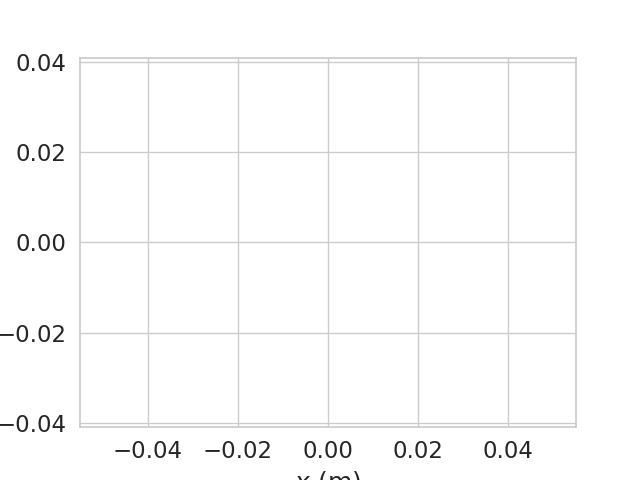

NameError: name 'traj_ref_complete' is not defined

In [31]:
# plot ground truth trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_ref_complete, marker_scale=2, downsample_ratio=20, plot_mode=plot_mode)
draw_start_and_end(ax, traj_ref_complete, plot_mode)
plot.traj(ax, plot_mode, traj_ref_complete, '--', "gray", "reference")
plt.title('Reference trajectory with pose')
plt.show()

# plot unaligned trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_est_unaligned, marker_scale=0.3, plot_mode=plot_mode)
draw_start_and_end(ax, traj_est_unaligned, plot_mode)
plot.traj(ax, plot_mode, traj_est_unaligned, '--', "gray", "reference")
plt.title('Estimated trajectory with pose')
plt.show()

In [32]:
plot_mode = plot.PlotMode.xyz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)

gt_df_downsampled = gt_df.iloc[:1200:100]


# reference trajectory
traj_ref_downsampled = pandas_bridge.df_to_trajectory(gt_df_downsampled)
draw_coordinate_axes(ax, traj_ref, plot_mode=plot_mode,marker_scale=3)
draw_coordinate_axes(ax, traj_est, plot_mode=plot_mode,marker_scale=3)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj(ax, plot_mode, traj_est, '--', "green", "estimate (aligned)")

plt.title('Trajectory with pose')
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'gt_df' is not defined

## Absolute-Pose-Error Plotting

Plot absolute-pose-error along the entire trajectory. APE gives a good sense of overall VIO performance across the entire trajectory.

### Absolute Translation Errors

The following two plots show 1) VIO's absolute translation errors (ATE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ATE.

In [33]:
# Plot APE of trajectory rotation and translation parts.
num_of_poses = traj_est.num_poses
traj_est.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))
traj_ref.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]

ape_tran = get_ape_trans((traj_ref, traj_est))
fig1 = plot_metric(ape_tran, "VIO ATE in Meters")
plt.show()

NameError: name 'traj_est' is not defined

In [34]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig = plot_traj_colormap_ape(ape_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by ATE")
plt.show()

NameError: name 'ape_tran' is not defined

### Absolute Rotation Errors

The following two plots show 1) VIO's absolute rotation errors (ARE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ARE. Note that the estimated trajectory used here, unlike ATE, is the unaligned, original estimated trajectory.

In [35]:
# Plot ARE
traj_est_unaligned.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

ape_rot = get_ape_rot((traj_ref, traj_est_unaligned))
fig2 = plot_metric(ape_rot, "VIO ARE in Degrees")
plt.show()

NameError: name 'traj_est_unaligned' is not defined

In [36]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig2 = plot_traj_colormap_ape(ape_rot, traj_ref, traj_est_unaligned,
                             plot_title="VIO Trajectory Tracking - Color Coded by ARE")
plt.show()

NameError: name 'ape_rot' is not defined

## Relative-Pose-Error Plotting

Plot relative-pose-error along the entire trajectory. RPE gives a good sense of overall VIO performance from one frame to the next.

In [37]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

NameError: name 'traj_ref' is not defined

### Relative Translation Errors

In [38]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

fig1 = plot_metric(rpe_tran, "VIO RTE in Meters")
fig2 = plot_traj_colormap_rpe(rpe_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RTE")
plt.show()

NameError: name 'traj_est' is not defined

### Relative Rotation Errors

In [39]:
fig1 = plot_metric(rpe_rot, "VIO RRE in Degrees")
fig2 = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

NameError: name 'rpe_rot' is not defined

In [40]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

NameError: name 'rpe_rot' is not defined

## Trajectory Plotting

Plot the aligned and associated estimated trajectory against ground truth.

In [41]:
# Plot the trajectories for quick error visualization.

fig = plt.figure()
traj_by_label = {
    "estimate (unaligned)": traj_est_unaligned,
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz, title="PIM Trajectory Tracking in 3D")
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'traj_est_unaligned' is not defined

## PIM Plotting

Plot preintegrated-imu-measurement estimates of current state over time. This comes in as a trajectory. The plots of error serve to help visualize the error in pim values over time.

Note that these pim values are built off the backend's estimation, not off of ground truth.

In [42]:
pim_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_pim_navstates.csv")
pim_df = pd.read_csv(pim_filename, sep=',', index_col=0)
rename_pim_df(pim_df)

gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]
# TODO: Add relative angle comparison plot between IMU and mono RANSAC

IOError: [Errno 2] File  does not exist: ''

In [ ]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unaligned = pandas_bridge.df_to_trajectory(pim_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

### Relative Angles
This plot compares the relative angles between GT and PIM outputs.

In [ ]:
# Convert to relative traj
traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref, up_to_scale=False)
traj_est_rel = convert_abs_traj_to_rel_traj(traj_est, up_to_scale=False)

# Plot the PIM angles
PIM_angles = []
PIM_angles_timestamps = []
for i in range(len(traj_est_rel._poses_se3)):
    PIM_angles_timestamps.append(traj_est_rel.timestamps[i])
    # quaternion to axisangle
    rotm = traj_est_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    PIM_angles.append(np.linalg.norm(rot_vec))


# Plot the GT angles
gt_angles = []
gt_angles_timestamps = []
for i in range(len(traj_ref_rel._poses_se3)):
    gt_angles_timestamps.append(traj_ref_rel.timestamps[i])
    # rotation matrix to axisangle
    rotm = traj_ref_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    gt_angles.append(np.linalg.norm(rot_vec))

    
plt.figure()
plt.plot(PIM_angles_timestamps, PIM_angles, 'r', label='PIM')
plt.plot(gt_angles_timestamps, gt_angles, 'b',  label='GT')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('Relative Angles [rad]')

plt.show()

In [ ]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

In [ ]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_metric(rpe_rot, "PIM RRE in Degrees")
plot_metric(rpe_tran, "PIM RTE in Meters")
plt.show()

In [ ]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="PIM Trajectory Tracking - Color Coded by RRE")
plt.show()

# Smart Factors
Plot smart factors vs. time

<IPython.core.display.Javascript object>


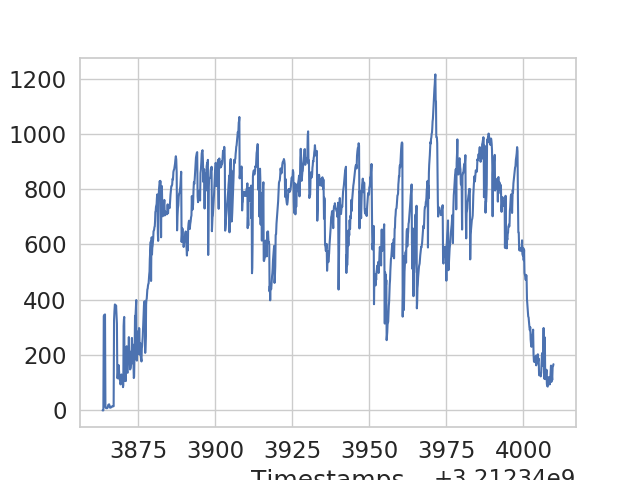

In [43]:
output_sf_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_smartFactors.csv")
output_sf_df = pd.read_csv(output_sf_filename, sep=',', index_col=0)
fig = plt.figure()
plt.plot(output_sf_df.timestamp_kf/1e9, output_sf_df.numValid)
plt.ylabel('Valid Smart Factors')
plt.xlabel('Timestamps')
plt.show()

# Biases
Plot biases of gyro and accelerometer

<IPython.core.display.Javascript object>


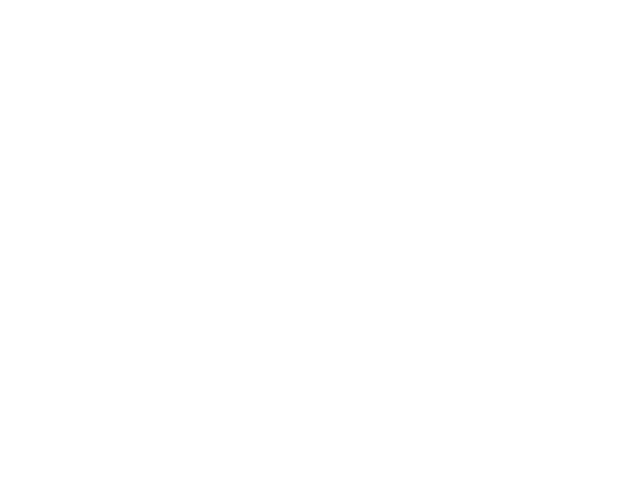

NameError: name 'output_poses_df' is not defined

In [44]:
fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bgx)
plt.plot(output_poses_df.index, output_poses_df.bgy)
plt.plot(output_poses_df.index, output_poses_df.bgz)
plt.ylabel('Gyro Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bax)
plt.plot(output_poses_df.index, output_poses_df.bay)
plt.plot(output_poses_df.index, output_poses_df.baz)
plt.ylabel('Acceleration Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()

In [26]:
from jinja2 import Environment, PackageLoader, select_autoescape
jinja_env = Environment(
    loader=PackageLoader('website', 'templates'),
    autoescape=select_autoescape(['html', 'xml'])
)

In [27]:
raw_output_web = web.RawOutputWebsiteBuilder(jinja_env, ".", "traj_vio.csv")

In [28]:
raw_output_web.add_dataset_to_website("RealSense", vio_output_dir)

In [29]:
raw_output_web.write_datasets_website()